# Running hydrological models on a remote server

Raven offers a mechanism to run hydrological model simulations on remote servers. One use case for this is to run Raven with remote input data. For example, if weather observations or predictions are stored in the cloud, it often makes more sense to launch simulations on the same cloud infrastructure rather than to download data locally then run Raven locally.

For this to work, you need access to a Raven server, and a client able to communicate with the server. In this example, we use the raven server hosted at `https://pavics.ouranos.ca`, and a client named `birdy`. Communications between the client and the server are made using the Open Geospatial Consortium (OGC) Web Processing Services (WPS) standard.

Here we use birdy's WPS client to launch the GR4J-CemaNeige hydrological model on the server and analyze the output. Other models can be launched using the same mechanism:
  - HBV-EC
  - HMETS
  - MOHYSE

Custom model configurations can also be used, but it is often more difficult to troubleshoot errors when the code runs on a remote server.

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
register_matplotlib_converters()

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple.
params = [0.529, -3.396, 407.29, 1.072, 16.9, 0.947]

# Local forcing files
ts=TESTDATA['raven-gr4j-cemaneige-nc-ts']

# Model configuration parameters
config = dict(
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    )

# Send a request to the server, instructing it to launch the GR4J-CN emulated model.
resp = wps.raven_gr4j_cemaneige(ts=str(ts), params=params, **config)


`resp` is the server's response to the request. It can be polled to check what is the status of the request, or see what percentage of the task is completed.

Once the simulation is complete, we fetch the output using the `get` method. With argument `asobj` set to False, only the URL of the output (stored on the remote server) is returned. To get the actual data, set `asobj` to True. Not only will this download the actual files locally, but also open them as python objects.

In [3]:
# The diagnostics output is CSV file.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_q45enn8e/Salmon-River-Near-Prince-George_meteo_daily.nc,-0.0371048,36.562,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. The `hydrograph` holds the simulated streamflow, while `storage` contains the different model state variables (soil water, snow, etc).

In [4]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 732, nbasins: 1)>
array([[ 0.      ],
       [ 0.165788],
       [ 0.559366],
       ...,
       [28.077935],
       [27.835868],
       [27.597955]])
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

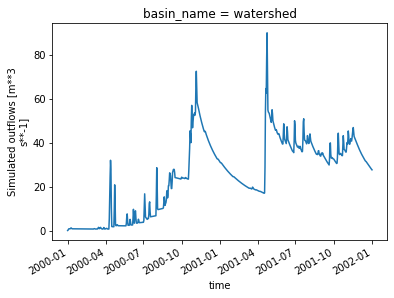

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
hydrograph.q_sim.plot(ax=ax1)
storage.Snow.plot(ax=ax2)

One of the advantage of working with `xarray` objects is that it makes time series analysis extremely useful. Computing monthly maxima or climatological means can be done with one-liners.

In [6]:
# Monthly maxima
mm = hydrograph.q_sim.resample(time="M").max()

# Climatological monthly means
hydrograph.q_sim.groupby('time.month').mean(dim='time')

Max:  <xarray.DataArray 'q_sim' ()>
array(89.92282654)
Mean:  <xarray.DataArray 'q_sim' ()>
array(24.68315955)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[14.51757387],
       [11.47384701],
       [10.07247867],
       [20.42010176],
       [24.37541489],
       [22.55812621],
       [23.56102364],
       [25.3008606 ],
       [28.72388591],
       [34.377813  ],
       [46.44695716],
       [34.09486238]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins


To run simulations with other emulated models, simply call one of these functions:
 - `raven_hbv_ec` (21 parameters)
 - `raven_hmets` (21 parameters)
 - `raven_mohyse` (10 parameters)

The docstring for each of these functions includes the name of expected model parameters.

## Server-side analysis

In the previous example, we downloaded the simulation results locally to compute means and plots the results. Another option is to keep the results on the server and use them as inputs to other analytical processes. In the next example, we're reusing the URL for the simulation outputs to launch a process computing objective functions. First, let's get the URLs for the simulation results.

In [ ]:
links = resp.get(asobj=False)
[hydrograph_url, storage_url, solution_url, diagnostics_url, rv_url] = links

# The `objective_function` computes from 1 to 17 objective functions.
resp_objfunc = wps.objective_function(obs=hydrograph_url, sim=hydrograph_url, name='agreementindex')
results = resp_objfunc.get(asobj=True)
print(results.metrics)

Now that we have numerical values for the goodness-of-fit, let's perform a visual inspection.

In [ ]:
# Call the objective function graphing wps while sending the hydrograph as input, which includes 'q_sim' and 'q_obs'
resp_graph = wps.graph_objective_function_fit(sims=hydrograph)
[graph_objfun_fit, graph_objfun_annual_fit] = resp_graph.get(asobj=True)

# The `graph_objfun_fit` object is a figure that the notebook will automatically display.
graph_objfun_fit